In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="rgb_array")
observation, info = env.reset()

In [3]:
env.action_space

Discrete(4)

In [4]:
env.observation_space

Discrete(64)

In [5]:
n_actions = env.action_space.n
n_states = env.observation_space.n

In [6]:
def render():
    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

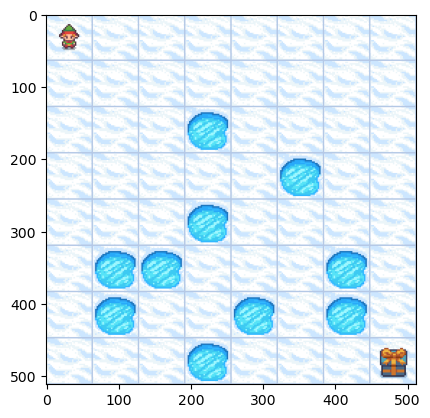

In [7]:
render()

In [8]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'H', b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'H', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'G']], dtype='|S1')

In [9]:
chr(env.unwrapped.desc[0][0][0])

'S'

In [10]:
# To get the list of terminated states so as to remove them from the policy or Q as starting states.
ignore_list = []
for i in range(len(env.unwrapped.desc)):
    for j in range(len(env.unwrapped.desc[0])):
        if(chr(env.unwrapped.desc[i][j][0]) != 'F' and chr(env.unwrapped.desc[i][j][0]) != 'S'):
            print(i, j)
            ignore_list.append(8*i + j)

2 3
3 5
4 3
5 1
5 2
5 6
6 1
6 4
6 6
7 3
7 7


In [11]:
ignore_list

[19, 29, 35, 41, 42, 46, 49, 52, 54, 59, 63]

In [12]:
# A policy will be a state-action pair dictionary, which will dictate what action to take when youre in a given state.
# We will initialize our policy with random values for the sake of it.
# Policy contains actions for terminate states as well, we will ignore those in the future 
# policy = {state:env.action_space.sample() for state in range(n_states)}

In [13]:
# Q is an action-value pair dictionary, which dictates what is the total reward which my action will lead to if the policy is followed
# Q = {state: (action, compute_state_values(state, action)) for state in states for action in range(n_actions)} 

In [14]:
# We are going to use Any-Visit Monte Carlo
# So we will have 1 global Q table and another table to keep count of the number of times an action on a given state has been performed
Q_mc = np.zeros((n_states, n_actions))
rewards = np.zeros((n_states, n_actions))
visits = np.zeros((n_states, n_actions))
n_episodes = 100000

In [15]:
# To update rewards and visits accordingly
def update(state, action, reward):
    rewards[state][action] += reward
    visits[state][action] += 1

In [16]:
def run_episodes_monte_carlo(n_episodes):
    for _ in range(n_episodes):
        observation, info = env.reset()
        state = observation
    
        # Run the episode till termination
        while True:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)     
            # To prevent wastage of time in executing actions which land agent on same block as they cant be executed
            if state == next_state:
                continue
            update(state, action, reward)
            state = next_state
            if (terminated or truncated): 
                break

# Update the Q_mc table after termination
def update_q_table_monte_carlo():
    for state in range(n_states):
        for action in range(n_actions):
            if visits[state][action] >= 1:
                Q_mc[state][action] =  rewards[state][action] / visits[state][action]

In [17]:
def rewards_result(Q):
    for i in range(n_states):
        for j in range(n_actions):
            if Q[i][j] > 0:
                print(f"state {i} and action {j} has a reward of {Q[i][j]}")

In [18]:
run_episodes_monte_carlo(n_episodes)
update_q_table_monte_carlo()
rewards_result(Q_mc)

state 55 and action 1 has a reward of 1.0
state 62 and action 2 has a reward of 1.0


In [19]:
# We are now going to implement SARSA
gamma = 0.9
alpha = 0.4
Q_sarsa = np.zeros((n_states, n_actions))

def update_q_table_sarsa(state, action, next_state, next_action, reward):
    old_value = Q_sarsa[state][action]
    new_value = Q_sarsa[next_state][next_action]

    Q_sarsa[state][action] = ((1-alpha) * old_value) + (alpha * (reward + gamma * new_value))

def run_episodes_sarsa(n_episodes):
    for _ in range(n_episodes):
        state, info = env.reset()
        action = env.action_space.sample()
        
        # Run the episode till termination
        while True:
            next_state, reward, terminated, truncated, info = env.step(action)
            # To prevent an episode from staying in one state infinitely as invalid actions are not classified as terminated or truncated
            if state == next_state:
                action = env.action_space.sample()
                continue
            next_action = env.action_space.sample()
            update_q_table_sarsa(state, action, next_state, next_action, reward)
            state, action = next_state, next_action
            if (terminated or truncated): 
                break

In [20]:
run_episodes_sarsa(n_episodes)
rewards_result(Q_sarsa)

state 0 and action 1 has a reward of 1.709904557671847e-07
state 0 and action 2 has a reward of 3.8215246472133295e-07
state 1 and action 0 has a reward of 1.0765155872358948e-07
state 1 and action 1 has a reward of 3.7343447881941403e-07
state 1 and action 2 has a reward of 5.374695511769796e-07
state 2 and action 0 has a reward of 4.869340063298521e-07
state 2 and action 1 has a reward of 3.862139548193696e-07
state 2 and action 2 has a reward of 2.316600417588951e-06
state 3 and action 0 has a reward of 2.072869814658223e-06
state 3 and action 1 has a reward of 3.6723446765332e-06
state 3 and action 2 has a reward of 1.4101317315153671e-05
state 4 and action 0 has a reward of 3.6006531412788977e-06
state 4 and action 1 has a reward of 1.5346304945816627e-05
state 4 and action 2 has a reward of 6.841211951198105e-05
state 5 and action 0 has a reward of 1.4531525373343302e-05
state 5 and action 1 has a reward of 5.260692487279181e-05
state 5 and action 2 has a reward of 0.000100148884

In [21]:
# Policy will be {state:action} pair
def compute_policy(Q):
    policy = {}
    for state in range(n_states):
        # Find the action with the highest Q-value for each state
        best_action = max(range(n_actions), key=lambda action: Q[state][action])
        policy[state] = best_action
    return policy

In [22]:
def reach_state(goal_state):
    state, info = env.reset()
    for i in range(goal_state//8):
        # Go down
        env.step(1) 
    goal_state = goal_state % 8 
    for i in range(goal_state):
        # Go right
        env.step(2)

In [23]:
gamma = 1

def compute_state_value(policy, state):
    total_reward = 0
    reach_state(state)
    while True:
        if state in ignore_list:
            break
        action = policy[state]
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            return total_reward
        if state == next_state:
            return 0
        state = next_state

In [24]:
def policy_evaluation(policy):
    V = {state: compute_state_value(policy, state) for state in range(n_states)}
    return V

In [25]:
def no_path(V):
    count = 0
    for i in range(n_states):
        if V[i] == 0:
            count += 1
    return count

In [26]:
# # Policy evaluation for a stochastic environment is done by taking the avg of rewards across multiple episodes 
# reward_per_learned_episode = []
# for episode in range(10000):
#     state, info = env.reset()
#     terminated = False
#     episode_reward = 0
#     while not (terminated or truncated):
#         action = policy[state]
#         new_state, reward, terminated, truncated, info = env.step(action)
#         state = new_state
#         episode_reward += reward
#     reward_per_learned_episode.append(episode_reward)

# avg_reward_per_learned_episode = np.mean(reward_per_learned_episode)
# print("Average reward per learned episode: ", avg_reward_per_learned_episode)

In [27]:
# Time to implement epsilon-greedy function now...

In [43]:
Q_greedy = np.zeros((n_states, n_actions))

In [44]:
epsilon = 0.8
min_epsilon = 0.3
decay = 0.9
def get_action(state):
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q_greedy[state])
    return action

In [45]:
def update_q_table_greedy(state, action, next_state, next_action, reward): # Using sarsa ofcourse
    old_value = Q_greedy[state][action]
    new_value = Q_greedy[next_state][next_action]
    print(state, action, next_state, next_action, reward )
    print(new_value, old_value)
    Q_greedy[state][action] = ((1-alpha) * old_value) + (alpha * (reward + gamma * new_value))

In [46]:
def run_episodes_greedy(n_episodes):
    global epsilon
    for _ in range(n_episodes):
        # print("state, action, next_state, next_action, next_next_state, reward, next_reward")
        state, info = env.reset()
        # env._max_episode_steps = float('inf')
        action = random.choice([1, 2])
        prev_action = None
        while True:
            _, next_state, reward, t = env.unwrapped.P[state][action][0]
            # if state == next_state:
            #     break
            next_action = get_action(next_state)
            while next_action == prev_action:
                next_action = get_action(next_state)
            _, next_next_state, next_reward, truncated = env.unwrapped.P[next_state][next_action][0]
            # print(state, action, next_state, next_action, next_next_state, reward, next_reward, t, truncated)
            if truncated:
                if next_reward != 1:
                    continue
                else:
                    update_q_table_greedy(state, action, next_state, next_action, reward)
                    update_q_table_greedy(next_state, next_action, next_next_state, env.action_space.sample(), next_reward)   
                    # print("next_state, next_action, next_next_state, env.action_space.sample(), next_reward")
                    # print(next_state, next_action, next_next_state, env.action_space.sample(), next_reward)
                    break                   
            if next_state == next_next_state:
                # if next_state == 63:
                #     next_state, reward, terminated, truncated, _ = env.step(action)
                #     update_q_table_greedy(state, action, next_state, next_action, reward)
                #     break
                # else:
                prev_action = next_action
                # print("vv")
                continue
            next_state, reward, terminated, truncated, _ = env.step(action)
            # print("(state, action, next_state, next_action, reward)")
            update_q_table_greedy(state, action, next_state, next_action, reward)
            # if terminated or truncated:
            #     if (state in ignore_list) or (next_state in ignore_list):
            #         print(state in ignore_list)
            #         print(next_state in ignore_list)
            #         print("state, action, next_state, next_action, reward, terminated, truncated")
            #     print("state, action, next_state, next_action, reward, terminated, truncated")
            if terminated or truncated:
                break
            state, action = next_state, next_action
        epsilon = max(min_epsilon, epsilon * decay)

In [47]:
run_episodes_greedy(100)
rewards_result(Q_greedy)

0 2 1 1 0.0
0.0 0.0
1 1 9 3 0.0
0.0 0.0
9 3 1 2 0.0
0.0 0.0
1 2 2 0 0.0
0.0 0.0
2 0 1 0 0.0
0.0 0.0
1 0 0 2 0.0
0.0 0.0
0 2 1 0 0.0
0.0 0.0
1 0 0 1 0.0
0.0 0.0
0 1 8 3 0.0
0.0 0.0
8 3 0 1 0.0
0.0 0.0
0 1 8 2 0.0
0.0 0.0
8 2 9 3 0.0
0.0 0.0
9 3 1 1 0.0
0.0 0.0
1 1 9 0 0.0
0.0 0.0
9 0 8 3 0.0
0.0 0.0
8 3 0 2 0.0
0.0 0.0
0 2 1 0 0.0
0.0 0.0
1 0 0 2 0.0
0.0 0.0
0 2 1 0 0.0
0.0 0.0
1 0 0 2 0.0
0.0 0.0
0 2 1 1 0.0
0.0 0.0
1 1 9 3 0.0
0.0 0.0
9 3 1 0 0.0
0.0 0.0
1 0 0 2 0.0
0.0 0.0
0 2 1 0 0.0
0.0 0.0
1 0 0 1 0.0
0.0 0.0
0 1 8 1 0.0
0.0 0.0
8 1 16 2 0.0
0.0 0.0
16 2 17 3 0.0
0.0 0.0
17 3 9 2 0.0
0.0 0.0
9 2 10 3 0.0
0.0 0.0
10 3 2 1 0.0
0.0 0.0
2 1 10 3 0.0
0.0 0.0
10 3 2 0 0.0
0.0 0.0
2 0 1 2 0.0
0.0 0.0
1 2 2 1 0.0
0.0 0.0
2 1 10 0 0.0
0.0 0.0
10 0 9 2 0.0
0.0 0.0
9 2 10 1 0.0
0.0 0.0
10 1 18 1 0.0
0.0 0.0
18 1 26 1 0.0
0.0 0.0
26 1 34 0 0.0
0.0 0.0
34 0 33 0 0.0
0.0 0.0
33 0 32 1 0.0
0.0 0.0
32 1 40 3 0.0
0.0 0.0
40 3 32 1 0.0
0.0 0.0
32 1 40 1 0.0
0.0 0.0
40 1 48 1 0.0
0.0 0.0
48 1 56 2 0

In [33]:
policy_mc = compute_policy(Q_mc)
policy_sarsa = compute_policy(Q_sarsa)
policy_greedy = compute_policy(Q_greedy)

In [34]:
V_mc = policy_evaluation(policy_mc)
V_sarsa = policy_evaluation(policy_sarsa)
V_greedy = policy_evaluation(policy_greedy)

In [35]:
no_path_mc = no_path(V_mc)
no_path_sarsa = no_path(V_sarsa)
no_path_greedy = no_path(V_greedy)
print(f"Total number of states you can start from is {n_states - len(ignore_list)} ")
print(f"Number of states in Monte-Carlo from which a path doesnt exist: {no_path_mc}")
print(f"Number of states in SARSA from which a path doesnt exist: {no_path_sarsa} ")
print(f"Number of states in GREEDY from which a path doesnt exist: {no_path_greedy} ")

Total number of states you can start from is 53 
Number of states in Monte-Carlo from which a path doesnt exist: 53
Number of states in SARSA from which a path doesnt exist: 21 
Number of states in GREEDY from which a path doesnt exist: 21 


In [36]:
def render_policy_execution(env, policy):
    state, info = env.reset()
    terminated, truncated = False, False
    total_reward = 0
    steps = 0

    while not (terminated or truncated):
        render()
        print(policy[state])
        action = policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1

    print(f"Total reward: {total_reward} in {steps} steps")

In [37]:
# render_policy_execution(env, policy_mc)

In [38]:
# render_policy_execution(env, policy_sarsa)

In [39]:
# render_policy_execution(env, policy_greedy)